# Tutorial 3: Reinforcement learning across temporal scales

**Week 1, Day 2: Comparing Tasks**

**By Neuromatch Academy**

__Content creators:__ Leila Wehbe

__Content reviewers:__ Names & Surnames

__Production editors:__ Names & Surnames

<br>

Acknowledgments: [ACKNOWLEDGMENT_INFORMATION]


___


# Tutorial Objectives

*Estimated timing of tutorial: [insert estimated duration of whole tutorial in minutes]*

By the end of this tutorial, participants will be able to:



In [1]:
# @title Tutorial slides

# @markdown These are the slides for the videos in all tutorials today


## Uncomment the code below to test your function

#from IPython.display import IFrame
#link_id = "<YOUR_LINK_ID_HERE>"

print("If you want to download the slides: 'Link to the slides'")
      # Example: https://osf.io/download/{link_id}/

#IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{link_id}/?direct%26mode=render", width=854, height=480)

If you want to download the slides: 'Link to the slides'


---
# Setup



In [2]:
# @title Install and import feedback gadget

# !pip3 install vibecheck datatops --quiet

# from vibecheck import DatatopsContentReviewContainer
# def content_review(notebook_section: str):
#     return DatatopsContentReviewContainer(
#         "",  # No text prompt - leave this as is
#         notebook_section,
#         {
#             "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
#             "name": "sciencematch_sm", # change the name of the course : neuromatch_dl, climatematch_ct, etc
#             "user_key": "y1x3mpx5",
#         },
#     ).render()

# feedback_prefix = "W1D2_T1"

In [3]:
# @title Install dependencies
# @markdown

#!pip install 

In [4]:
# @title Import dependencies
# @markdown

# Set up logging
import logging
import requests
import hashlib
import os
import matplotlib.pyplot as plt
from IPython.display import IFrame, display, Image


In [5]:
# @title Figure settings
# @markdown

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perform high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [6]:
# @title Plotting functions
# @markdown


In [7]:
#@title Helper functions
# @markdown

In [8]:
#@title Data retrieval
# @markdown

def download_file(fname, url, expected_md5):
    """
    Downloads a file from the given URL and saves it locally.
    Verifies the integrity of the file using an MD5 checksum.

    Args:
    - fname (str): The local filename/path to save the downloaded file.
    - url (str): The URL from which to download the file.
    - expected_md5 (str): The expected MD5 checksum to verify the integrity of the downloaded data.
    """
    if not os.path.isfile(fname):
        try:
            response = requests.get(url)
            response.raise_for_status()  # Raises an HTTPError for bad responses
            file_content = response.content
            if hashlib.md5(file_content).hexdigest() == expected_md5:
                with open(fname, "wb") as file:
                    file.write(file_content)
                print(f"{fname} has been downloaded and verified successfully.")
            else:
                print(f"Integrity check failed for {fname}.")
        except requests.RequestException as e:
            print(f"Failed to download {fname}. Error: {str(e)}")

# Define the list of images to download
images_to_download = [
    ("cummulative_regret.png", "https://osf.io/ea2wz/download", "3ca8c9ee5148ed40b063b494d945ff21"),
    ("evolution.png", "https://osf.io/k8e69/download", "8ecaf3ac74d6202d833d4c1c53424f73"),
    ("exploration_exploitation_tradeoff.png", "https://osf.io/qmr5y/download", "dd19442f893f9ecf3d0507d551f2383a"),
    ("learning_temporal_scales.png", "https://osf.io/nfkth/download", "c3cbefaf79c27ded2fd5e61a5cc0b38c"),
    ("model_architecture.png", "https://osf.io/2hya6/download", "98ab0179e5e32c5c60c854c6997b49ba")
]

# Process the downloads
for filename, url, md5_hash in images_to_download:
    download_file(filename, url, md5_hash)

# Reinforcement learning across temporal scales

[This tutorial is work-in progress. We will outline the general plan here.]

In [ ]:
# @title Video 1: Continual learning

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'BOGX0KvpnEU')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In recent years, the field of neuro-AI has increasingly drawn upon insights and findings from neuroscience to inspire innovations and advancements in AI algorithms and models and vice versa. This interdisciplinary approach has opened new avenues for understanding and developing AI systems that emulate the complexity and efficiency of the human brain to better model the human brain or to gain new functionality in AI systems.

An important work in this domain is the following paper:

[1] Wang, Jane X., Zeb Kurth-Nelson, Dharshan Kumaran, Dhruva Tirumala, Hubert Soyer, Joel Z. Leibo, Demis Hassabis, and Matthew Botvinick. **"Prefrontal cortex as a meta-reinforcement learning system."** Nature neuroscience 21, no. 6 (2018): 860-868. 

Available at: https://www.nature.com/articles/s41593-018-0147-8

This paper by Wang et al. (2018) aims to reconciliate the theory of dopamine based-learning in the striatum with findings that the prefrontal cortex (PFC) show activations related to actions, states and rewards. The paper presents a theory proposing that the human prefrontal cortex (PFC) along with the basal ganglia can be modeled as a recurrent neural network that functions akin to a meta-reinforcement learning (meta-RL) system. Dopamine based learning allows the weights of the model PFC to change to allow it to learn a second RL algorithm dynamically, as the properties of the environment changes. The new algorithm is implemented by the activations of the PFC, and is independent of the original training task. This allows the PFC to adapt to new situations using prior learning experiences, essentially learning to learn.

We will explore here the demo that the authors showcase in their Figure 1, which shows that after training a recurrent neural network that serves as a PFC model on different contexts, the resulting network is a full-fledged RL procedure. We see how the trained network adapts to the fast changing latent world state, and how it behaves likes an RL algorithm (e.g., how it performs an exploration-exploitation tradeoff).

### Task
The task is a two-armed bandit task, where the agent choses one of the arms (left or right), and each arm has a probability of yielding a reward (the probabilities add up to 1). Each episode consists of 100 trials, and at the end of the episode, the probabilities change, and the agent needs to learn the new probabilities to know which arm to choose. In the framework we discussed in the lecture, the change of the probabilities corresponds to the fast latent world state. Further, the RL agents are trained in two contexts (slow): one in which the probilities of the consecutive episodes are uncorrelated, and one in which they are correlated.


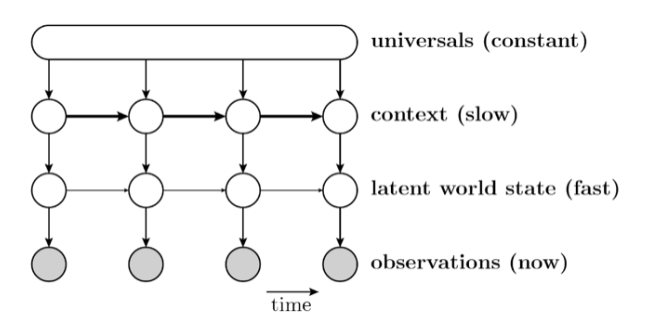

In [9]:
# @title Show image
# @markdown

display(Image(filename="learning_temporal_scales.png"))

*Figure A - Learning temporal scales*

### Architecture

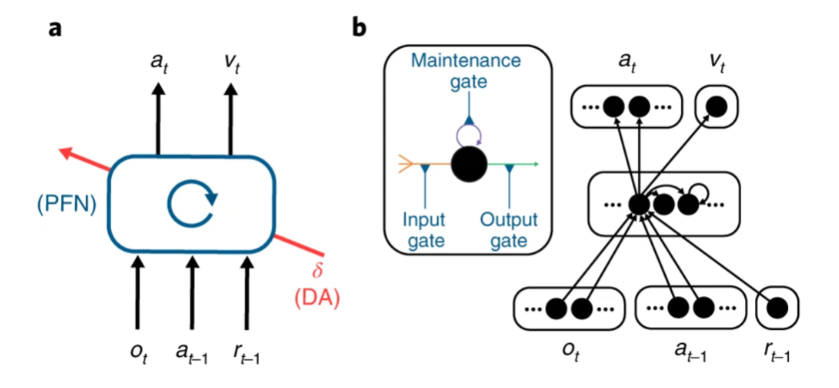

In [10]:
# @title Show image
# @markdown

display(Image(filename="model_architecture.png"))

*Figure B - Model architecture. Adapted from Figure 1 of Wang et al.*

The PFC, along with the basal ganglia and directly connected thalamus, are modeled as a reccurent network. The synaptic weights are adjusted during training. a = action, r = reward, v = state value. Specifically, the algorithm is implemented as an LSTM (figure b above shows the model in more detail, along with an inset of one LSTM model unit illustrating the maintenance mechanism).


### Training an agent in an uncorrelated setting - exploration/exploitation tradeoff

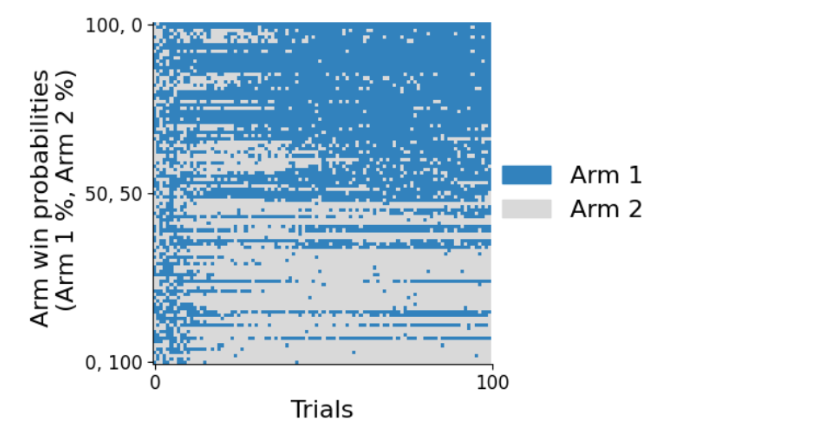

In [11]:
# @title Show image
# @markdown
display(Image(filename="exploration_exploitation_tradeoff.png"))


*Figure C - Exploration exploitation tradeoff. From the https://github.com/nathanwispinski/meta-rl repo which adapts the Wang et al. model*

In figure C, you can find the performance of the LSTM model after it has been trained on the uncorrelated task. Each row corresponds to an episode, and the episodes are ordered in terms of the reward probability of Arm 1 (top = 100%, bottom = 0%). In the top half of the matrix, the optimal choise is Arm 1, and in the bottom half, the optimal choice is Arm 2.

### Discussion point

Observe the actions of the model for different episodes. How do they vary as the probabilities vary? What sets of probabilities are easy to learn? And which are hard to learn?

The shift from exploration to exploitation in neural networks, particularly in reinforcement learning (RL) settings, is crucial for understanding how an agent adapts and optimizes its strategy based on the reward structure of the environment.

- Exploration involves the agent trying different actions to gather more information about the environment. In the early stages, the agent lacks enough data to make informed decisions, hence it explores to improve its knowledge base.
- Exploitation starts once the agent has sufficient information on which actions lead to higher rewards. It begins to leverage this knowledge to maximize its reward by choosing actions that it believes have the best outcomes based on past experiences.

The transition from exploration to exploitation occurs more slowly in more difficult problems, as indicated in the provided figure (part c). In episodes with reward parameters such as 0.6 and 0.4, where the difference in reward probability between actions is smaller, it's tougher for the agent to ascertain which action is better. Hence, more exploration is needed before a confident shift to exploitation can occur.

In contrast, with a larger discrepancy in rewards (e.g., 0.75 vs. 0.25), the agent can more quickly determine the more rewarding action and thus switch to exploitation sooner.

### Uncorrelated vs. correlated settings, seen through cummulative regret 
Cummulative regret measures the expected regret of not having taken the best option in hindsight. In our setting, at each trial, it corresponds to the previous trials in the same episode in which the optimal arm was not sampled.


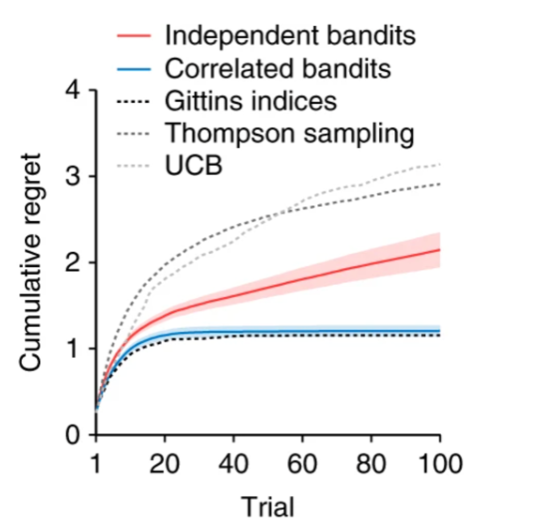

In [12]:
# @title Show image
# @markdown
display(Image(filename="cummulative_regret.png"))

*Figure D - Cummulative Regret tested on a probability setting of 0.25, 0.75. Adapted from Figure 1 of Wang et al.*

Figure D shows the cummulative regret after training in the two context, along with comparison with several standard machine-learning bandit algorithms. Notice how training the algorithm in a correlated setting is able to utilize the structure of the task and identify the optimal arm more rapidly.

### The learned model dynamics implement an RL algorithm

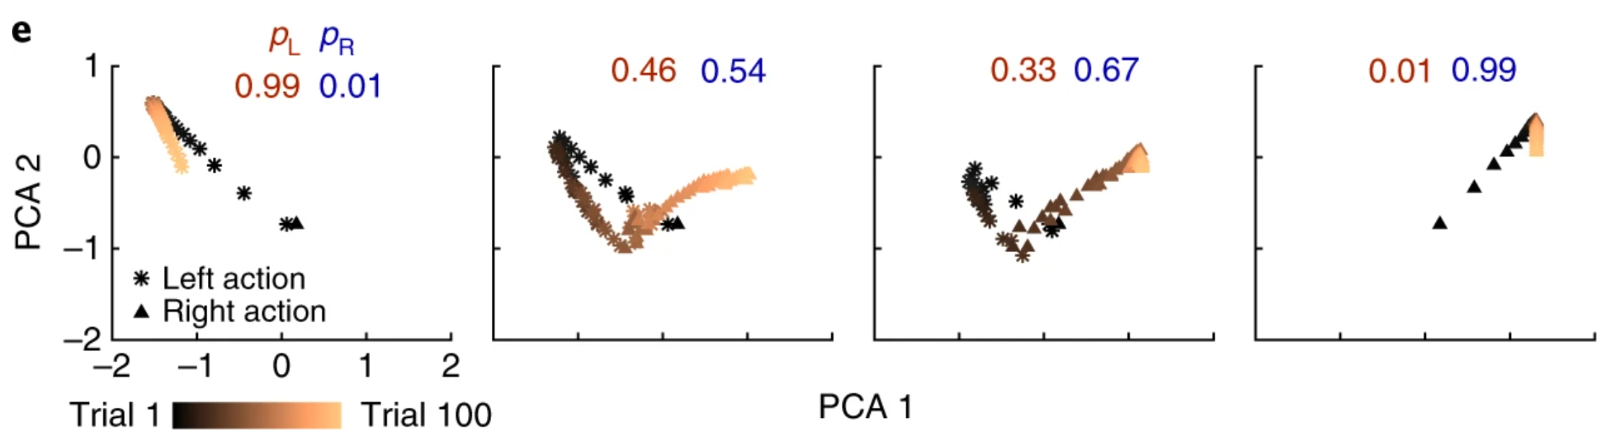

In [13]:
# @title Show image
# @markdown
display(Image(filename="evolution.png"))

*Figure E - Evolution of model activations during different episodes. Adapted from Figure 1 of Wang et al.*

In Figure E, the PCs of the model activations are obtained and the 100 trials in four episodes with specific probabilities are shown, projected onto PC1 and PC2. Observe the different patterns:
- Which two episodes show a fast convergence to an optimal action? How does this manifest?
- In the other two episodes, describe the trajectory of the activations, does the model change its estimation of the optimal arm? What leads to this change?

The adaptation to fast-changing latent variables, as described in the changes in activation patterns over trials, also shows the algorithm's capability to adjust its internal representations based on the feedback from the environment. This reflects a meta-learning capability where the algorithm doesn't just learn the optimal action but learns how to learn in the given environment, a crucial aspect in dynamic settings where understanding and leveraging latent task structures are key to superior performance.

- The first and last episode show a very fast convergence towards the optimal arm. The trajectory is very fast towards one or the other side of the PC space.

- In the middle two episodes, it takes longer to converge (they also correspond to more difficult settings). The model actually first decide on left, but then after sampling a right action, end up convering on right. 
